In [1]:
!pip install yfinance
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.2 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import datetime
import tensorflow as tf
import xgboost as xgb
import warnings


from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_validate

from numpy import mean, std, sqrt
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima import auto_arima
from datetime import datetime

time_start = datetime.now()

In [3]:
## Setting up the start and end date
start_date = '2003-01-01'
end_date = '2023-11-04'

## Data Preprocessing

In [4]:
# Extract market data of currency symbol
currency = 'EURINR'
data = yf.download(currency+'=X', start=start_date, end=end_date)

data = data.reset_index()

[*********************100%%**********************]  1 of 1 completed


In [5]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5170.000000,5170.000000,5170.000000,5170.000000,5170.000000,5170.0
mean,71.248620,71.633342,70.928559,71.276404,71.276404,0.0
std,11.083920,11.086380,11.096142,11.088501,11.088501,0.0
min,6.229900,51.924999,6.229900,51.814999,51.814999,0.0
25%,61.106750,61.449749,60.768751,61.044998,61.044998,0.0
50%,71.125500,71.487499,70.816002,71.133003,71.133003,0.0
75%,80.408247,80.828751,80.125000,80.466501,80.466501,0.0
max,92.124001,92.514000,91.982002,92.133003,92.133003,0.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170 entries, 0 to 5169
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5170 non-null   datetime64[ns]
 1   Open       5170 non-null   float64       
 2   High       5170 non-null   float64       
 3   Low        5170 non-null   float64       
 4   Close      5170 non-null   float64       
 5   Adj Close  5170 non-null   float64       
 6   Volume     5170 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 282.9 KB


## Data Visualization

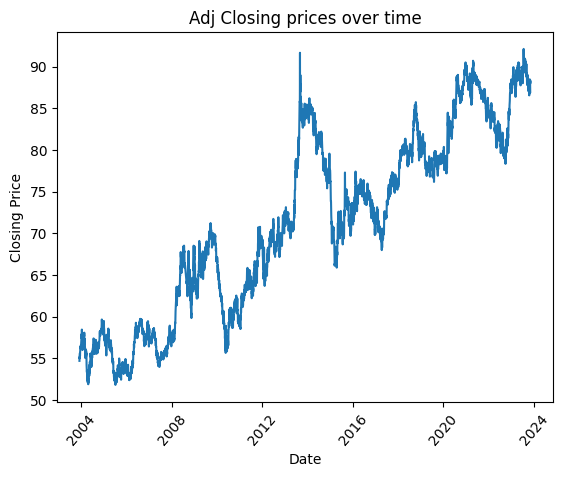

In [8]:
# Plotting the Adj closing prices
plt.plot(data['Date'] ,data['Adj Close'])
plt.title("Adj Closing prices over time")
plt.xlabel("Date")
plt.ylabel("Closing Price")

plt.xticks(rotation=50)
plt.savefig('EUROINR Adj closing price')

plt.show()

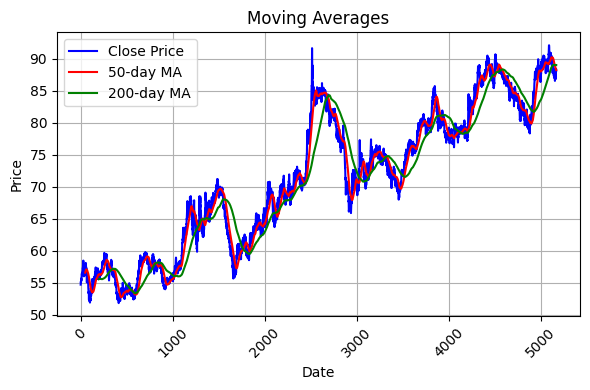

In [9]:
plt.figure(figsize=(6,4))
plt.plot(data.index, data["Adj Close"], label="Close Price", color='b')
plt.plot(data.index, data["Adj Close"].rolling(window=50).mean(), label="50-day MA", color='r')
plt.plot(data.index, data["Adj Close"].rolling(window=200).mean(), label="200-day MA", color='g')
plt.title("Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

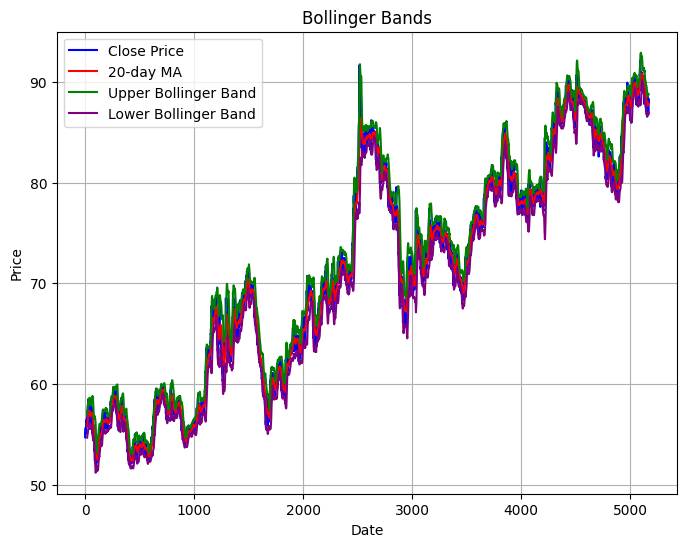

In [10]:
data['20MA'] = data['Adj Close'].rolling(window=20).mean()
data['Upper'] = data['20MA'] + 2 * data['Adj Close'].rolling(window=20).std()
data['Lower'] = data['20MA'] - 2 * data['Adj Close'].rolling(window=20).std()
plt.figure(figsize=(8, 6))
plt.plot(data.index, data['Adj Close'], label='Close Price', color='blue')
plt.plot(data.index, data['20MA'], label='20-day MA', color='red')
plt.plot(data.index, data['Upper'], label='Upper Bollinger Band', color='green')
plt.plot(data.index, data['Lower'], label='Lower Bollinger Band', color='purple')
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()


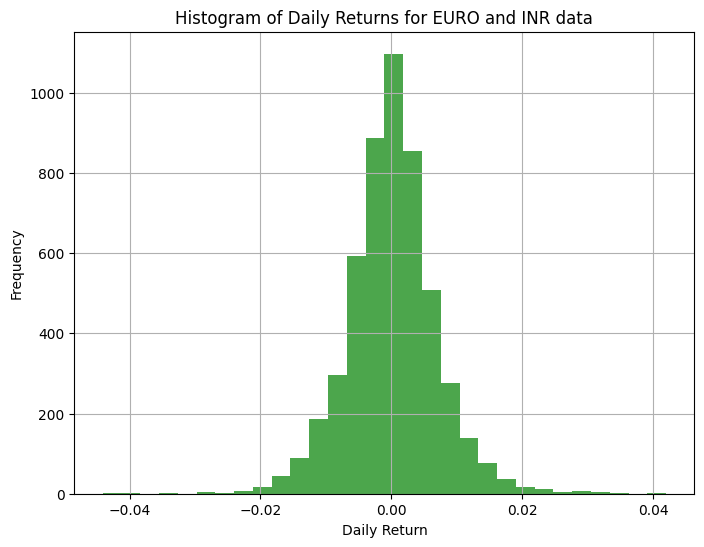

In [11]:
data['Daily Return'] = data['Adj Close'].pct_change()
plt.figure(figsize=(8, 6))
plt.hist(data['Daily Return'].dropna(), bins=30, color='green', alpha=0.7)
plt.title('Histogram of Daily Returns for EURO and INR data')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)

## Splitting of data

In [13]:
# Defining dataset for training, test and validation
feature_data_set = data

train_data_size = int(len(feature_data_set) * 0.80)  ## 80% dataset for training ##
test_data_size = int(len(feature_data_set) * 0.10)   ## 10% dataset for training ##
val_data_size = len(feature_data_set) - train_data_size - test_data_size  ## Validation dataset ##

# Split the data into training, testing, and validation sets
train_data = feature_data_set.iloc[:train_data_size]
validation_data = feature_data_set.iloc[train_data_size: train_data_size + test_data_size]
test_data = feature_data_set.iloc[train_data_size + val_data_size:]

# Print the shapes of the split sets
print(train_data.shape, validation_data.shape, test_data.shape)

(4136, 11) (517, 11) (517, 11)


In [14]:
train_filter_data = train_data.filter(['Adj Close'])
train_data_set = train_filter_data.values

test__filter_data = test_data.filter(['Adj Close'])
test_data_set = test__filter_data.values

validation_filter_data = validation_data.filter(['Adj Close'])
validation_data_set = validation_filter_data.values

train_data_set.shape, test_data_set.shape, validation_data_set.shape

((4136, 1), (517, 1), (517, 1))

In [17]:
## scaling of data
scaler = MinMaxScaler()

Scaled_train_data_set = scaler.fit_transform(train_data_set)
Scaled_val_data_set = scaler.fit_transform(validation_data_set)
Scaled_test_data_set = scaler.fit_transform(test_data_set)

In [18]:
## data spliting into x and y train
X_train = []
y_train = []

step_index = 30

for index in range(len(train_data) - step_index):
    X_train.append(Scaled_train_data_set[index:index + step_index, 0])
    y_train.append(Scaled_train_data_set[step_index + index, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Convert to NumPy array
X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape the input data to match deep learning models
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape(y_train.shape[0],1)

# Print the reshaped data
print(X_train.shape , y_train.shape)

(4106, 30, 1) (4106, 1)


In [19]:
## data spliting into x and y validate
X_Val = []
y_Val = []

for index in range(len(validation_data)-step_index):
    X_Val.append(Scaled_val_data_set[index : index + step_index, 0])
    y_Val.append(Scaled_val_data_set[step_index + index, 0])

X_Val, y_Val = np.array(X_Val), np.array(y_Val)

# Covert to NumPy array
X_Val = np.array(X_Val)
y_Val = np.array(y_Val)

# Reshaped input data to match with deep learning model
y_Val = y_Val.reshape(y_Val.shape[0] , 1)
X_Val = np.reshape(X_Val, (X_Val.shape[0], X_Val.shape[1], 1))

# Print the reshaped data
print(X_Val.shape, y_Val.shape)

(487, 30, 1) (487, 1)


In [20]:
## data spliting into x and y test
X_test = []
y_test = []

for index in range(len(test_data) - step_index):
    X_test.append(Scaled_test_data_set[index : index + step_index, 0])
    y_test.append(Scaled_test_data_set[step_index + index, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Convert to NumPy array
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape the input data to match the LSTM input shape [samples, timesteps, features]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test=y_test.reshape(y_test.shape[0],1)

# Print the reshaped data
print(X_test.shape, y_test.shape)

(487, 30, 1) (487, 1)


## common function

In [21]:
# function for mean square error
def mse_func(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) ** 2)

In [22]:
# function for root mean square error
def rmse_func(y_true, y_pred):
    rmse_val = math.sqrt(mean_squared_error(y_true, y_pred))
    return rmse_val

In [23]:
# function for mean absolute percentage error
def mape_func(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**GRU Model Fitting**

Epoch 1/30
116/116 [==============================] - 22s 123ms/step - loss: 0.0140 - val_loss: 4.8359e-04
Epoch 2/30
116/116 [==============================] - 14s 119ms/step - loss: 4.9561e-04 - val_loss: 4.1340e-04
Epoch 3/30
116/116 [==============================] - 14s 120ms/step - loss: 4.2482e-04 - val_loss: 2.9967e-04
Epoch 4/30
116/116 [==============================] - 15s 126ms/step - loss: 3.8957e-04 - val_loss: 4.3502e-04
Epoch 5/30
116/116 [==============================] - 14s 119ms/step - loss: 3.5207e-04 - val_loss: 2.5576e-04
Epoch 6/30
116/116 [==============================] - 15s 132ms/step - loss: 3.6356e-04 - val_loss: 2.4005e-04
Epoch 7/30
116/116 [==============================] - 14s 119ms/step - loss: 2.9030e-04 - val_loss: 2.1457e-04
Epoch 8/30
116/116 [==============================] - 14s 120ms/step - loss: 3.0941e-04 - val_loss: 2.6858e-04
Epoch 9/30
116/116 [==============================] - 14s 118ms/step - loss: 2.5857e-04 - val_loss: 3.5510e-04
Epoch

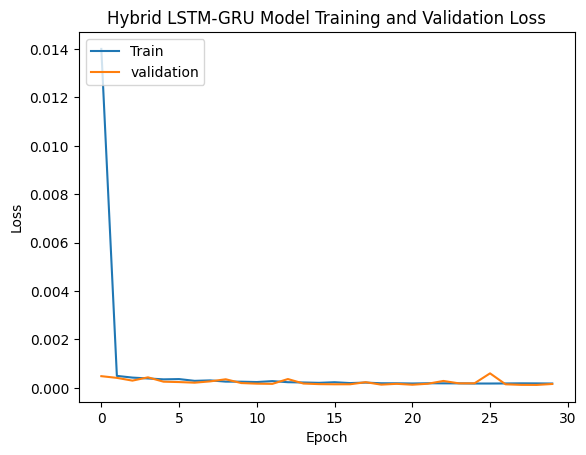

In [24]:
model_hybrid_gru_lstm = Sequential()

model_hybrid_gru_lstm.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(step_index, 1)))
model_hybrid_gru_lstm.add(GRU(units=64, activation='relu', return_sequences=False))
model_hybrid_gru_lstm.add(Dense(units=1))

model_hybrid_gru_lstm.compile(optimizer='adam', loss='mean_squared_error')

GRU_LSTM_Hybrid_model = model_hybrid_gru_lstm.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)

plt.plot(GRU_LSTM_Hybrid_model.history['loss'])
plt.plot(GRU_LSTM_Hybrid_model.history['val_loss'])

plt.title('Hybrid LSTM-GRU Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.savefig('Hybrid LSTM-GRU Model-Loss.png' )
plt.show()

In [25]:
hybrid_predictions = model_hybrid_gru_lstm.predict(X_Val)

hybrid_predictions_scale_original = scaler.inverse_transform(hybrid_predictions)

y_Val_scale_original = scaler.inverse_transform(y_Val)

16/16 [==============================] - 0s 11ms/step


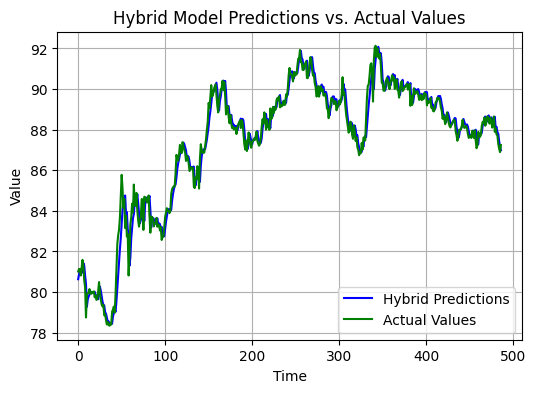

In [26]:
x = range(len(hybrid_predictions_scale_original))

plt.figure(figsize=(6,4))
plt.plot(x, hybrid_predictions_scale_original, label='Hybrid Predictions', color='blue')
plt.plot(x, y_Val_scale_original, label='Actual Values', color='green')

plt.title('Hybrid Model Predictions vs. Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [27]:
mape_val = mape_func(y_Val_scale_original, hybrid_predictions_scale_original)

mse_val = mse_func(y_Val_scale_original, hybrid_predictions_scale_original)

rmse_val = rmse_func(y_Val_scale_original, hybrid_predictions_scale_original)

print('Hybrid model performance during validation phase')
print("Hybrid_RMSE:", rmse_val)
print("Hybrid_MSE:", mse_val)
print("Hybrid_MAPE:", mape_val)

Hybrid model performance during validation phase
Hybrid_RMSE: 0.5129453389673406
Hybrid_MSE: 0.26311292076832
Hybrid_MAPE: 0.4109792727241944


**GRU LSTM Model Testing**

In [28]:
hybrid_predictions = model_hybrid_gru_lstm.predict(X_test)

predictions_scale_original = scaler.inverse_transform(hybrid_predictions)

y_test_scale_original = scaler.inverse_transform(y_test)

16/16 [==============================] - 1s 32ms/step


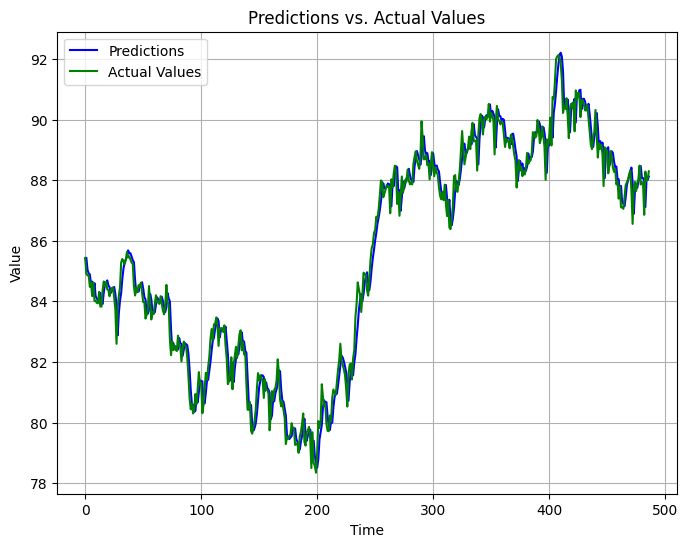

In [29]:
x = range(len(predictions_scale_original))

plt.figure(figsize=(8, 6))
plt.plot(x, predictions_scale_original, label='Predictions', color='blue')
plt.plot(x, y_test_scale_original, label='Actual Values', color='green')

plt.title('Predictions vs. Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

## model performance on testing data

In [30]:
mse_test = mse_func(y_test_scale_original, predictions_scale_original)

rmse_test = rmse_func(y_test_scale_original, predictions_scale_original)

mape_test = mape_func(y_test_scale_original, predictions_scale_original)

print('Hybrid model performance during testing phase')

print("Hybrid MSE:", mse_test)

print("Hybrid RMSE:", rmse_test)

print("Hybrid MAPE:", mape_test)

Hybrid model performance during testing phase
Hybrid MSE: 0.25081884586041914
Hybrid RMSE: 0.5008181764477195
Hybrid MAPE: 0.4567373304503206


**Hybrid GRU Model Prediction**

In [ ]:
num_future_days = 14

lastest_date = pd.to_datetime(data['Date'].iat[-1])

# Generate the list of dates for forecast
next_14_days = [lastest_date + datetime.timedelta(days=i) for i in range(1, num_future_days + 1)]

# Print the predicted rates for the next month
for date, price in zip(next_14_days[:14], predictions_scale_original[-14:]):
    print(f"{date.date()}: {price}")

2023-11-04: [86.91564]
2023-11-05: [87.3583]
2023-11-06: [87.6044]
2023-11-07: [87.54078]
2023-11-08: [87.71839]
2023-11-09: [87.87434]
2023-11-10: [88.22603]
2023-11-11: [87.97429]
2023-11-12: [87.920616]
2023-11-13: [87.834595]
2023-11-14: [87.08192]
2023-11-15: [87.7759]
2023-11-16: [87.790276]
2023-11-17: [87.89995]


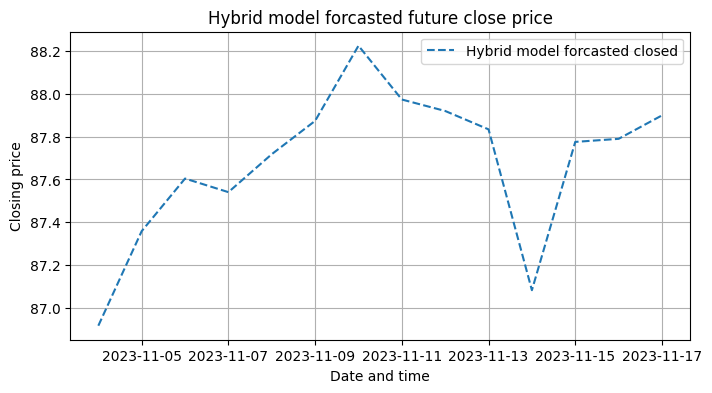

In [ ]:
plt.figure(figsize=(8,4))

plt.plot(next_14_days[:14], predictions_scale_original[-14:], label='Hybrid model forcasted closed', linestyle='dashed')

plt.xlabel('Date and time')
plt.ylabel('Closing price')
plt.title('Hybrid model forcasted future close price')
plt.legend()
plt.grid(True)
plt.show()

**CNN model**

**Model Fitting**

In [31]:
# Define the CNN model
cnn_model = Sequential()

# Add a 1D convolutional layer with 32 filters, kernel size 3, and ReLU activation
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))

# Add a max pooling layer with pool size 2
cnn_model.add(MaxPooling1D(pool_size=2))

# Flatten the output from the previous layer
cnn_model.add(Flatten())

# Add a fully connected dense layer with 64 units and ReLU activation
cnn_model.add(Dense(64, activation='relu'))

# Add a final dense layer with 1 unit and linear activation for regression
cnn_model.add(Dense(1, activation='linear'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
cnn_model.summary()

#compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

#train the model
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=16, epochs=20)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                28736     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 28929 (113.00 KB)
Trainable params: 28929 (113.00 KB)
Non-trainable params: 0 (0.00 Byte)
________________

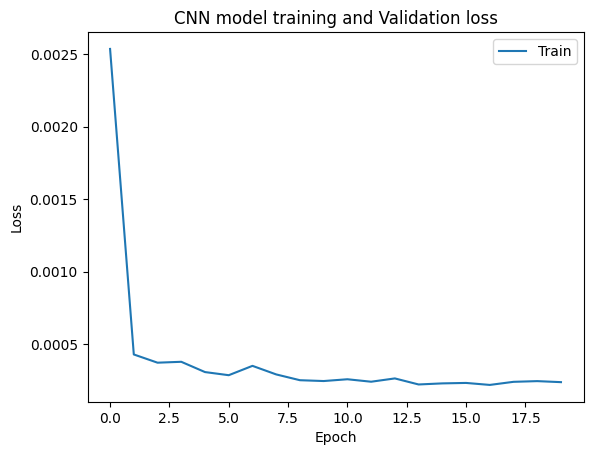

In [32]:
plt.plot(cnn_model_history.history['loss'])

plt.title('CNN model training and Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Train', 'validation'], loc='best')
plt.savefig('CNN_model_loss.png' )
plt.show()

In [33]:
history_test = cnn_model.fit(X_test, y_test, batch_size=16, epochs=30)

Epoch 1/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0017
Epoch 2/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 3/30
31/31 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 4/30
31/31 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 5/30
31/31 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 6/30
31/31 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 7/30
31/31 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 8/30
31/31 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 9/30
31/31 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 10/30
31/31 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 11/30
31/31 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 12/30
31/31 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 13/30
31/31 [============================

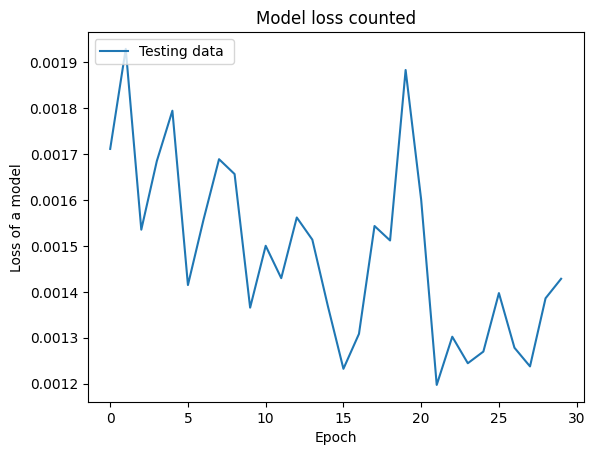

In [34]:
#show model loss
plt.plot(history_test.history['loss'])
plt.title('Model loss counted')
plt.ylabel('Loss of a model')
plt.xlabel('Epoch')
plt.legend(['Testing data '], loc='upper left')
plt.show()

In [35]:
predict = cnn_model.predict(X_test)

predict_original_scale = predict * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

y_test_original = y_test * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

16/16 [==============================] - 0s 2ms/step


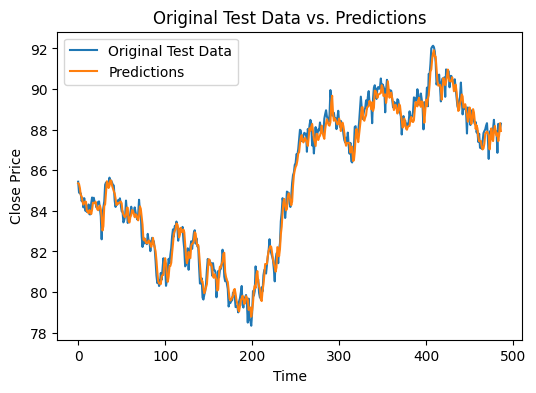

In [36]:
plt.figure(figsize=(6, 4))

# Plot original test data
plt.plot(y_test_original, label='Original Test Data')

# Plot predicted data
plt.plot(predict_original_scale, label='Predictions')

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Original Test Data vs. Predictions')
plt.legend()
plt.savefig('Exchange rate test and actual prediction')
plt.show()

In [37]:
rmse_val = rmse_func(y_test_original, predict_original_scale)
mape_val = mape_func(y_test_original, predict_original_scale)
mse_val = mse_func(y_test_original, predict_original_scale)

print('model performance')
print("RMSE:", rmse_val)
print("MAPE:", mape_val)
print("MSE:", mse_val)

model performance
RMSE: 0.464307000976139
MAPE: 0.42954001442194356
MSE: 0.21558099115545631


In [38]:
history_val = cnn_model.fit(X_Val, y_Val, batch_size=16, epochs=30)

Epoch 1/30
31/31 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 2/30
31/31 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 3/30
31/31 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 4/30
31/31 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 5/30
31/31 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 6/30
31/31 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 7/30
31/31 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 8/30
31/31 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 9/30
31/31 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 10/30
31/31 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 11/30
31/31 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 12/30
31/31 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 13/30
31/31 [==============================

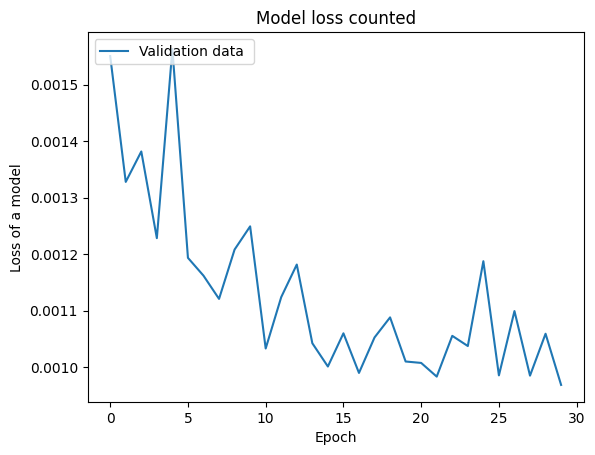

In [39]:
#show model loss
plt.plot(history_val.history['loss'])
plt.title('Model loss counted')
plt.ylabel('Loss of a model')
plt.xlabel('Epoch')
plt.legend(['Validation data '], loc='upper left')
plt.show()

In [40]:
predict_val = cnn_model.predict(X_Val)

predict_original_val = predict_val * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

y_Val_original = y_Val * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

16/16 [==============================] - 0s 2ms/step


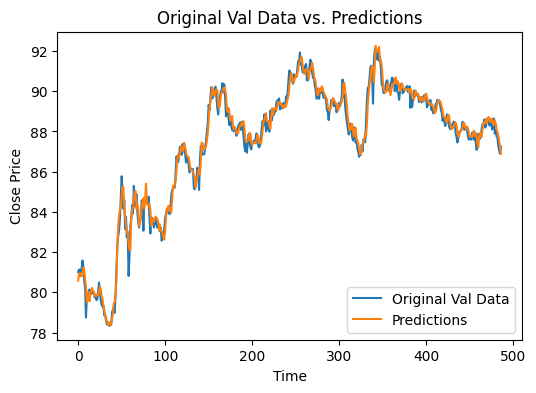

In [41]:
plt.figure(figsize=(6, 4))

# Plot original test data
plt.plot(y_Val_original, label='Original Val Data')

# Plot predicted data
plt.plot(predict_original_val, label='Predictions')

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Original Val Data vs. Predictions')
plt.legend()
plt.savefig('Exchange rate val and actual prediction')
plt.show()

In [42]:
rmse_val = rmse_func(y_Val_original, predict_original_val)
mse_val = mse_func(y_Val_original, predict_original_val)
mape_val = mape_func(y_Val_original, predict_original_val)

print('model performance')
print("RMSE:", rmse_val)
print("MSE:", mse_val)
print("MAPE:", mape_val)

model performance
RMSE: 0.41403707237331966
MSE: 0.17142669729946955
MAPE: 0.36625381363186227


In [ ]:
num_future_days = 14

lastest_date = pd.to_datetime(data['Date'].iat[-1])

# Generate the list of dates for forecast
next_14_days = [lastest_date + datetime.timedelta(days=i) for i in range(1, num_future_days + 1)]

# Print the predicted rates for the next month
for date, price in zip(next_14_days[:14], predict_original_scale[-14:]):
    print(f"{date.date()}: {price}")

2023-11-04: [87.154434]
2023-11-05: [87.637566]
2023-11-06: [88.019844]
2023-11-07: [87.65248]
2023-11-08: [87.57575]
2023-11-09: [87.66303]
2023-11-10: [88.11895]
2023-11-11: [87.965675]
2023-11-12: [87.77647]
2023-11-13: [87.70985]
2023-11-14: [87.62535]
2023-11-15: [88.00539]
2023-11-16: [88.483925]
2023-11-17: [87.87155]


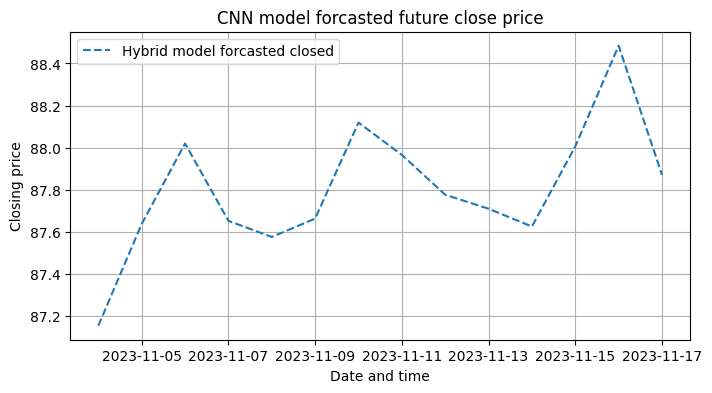

In [ ]:
plt.figure(figsize=(8,4))

plt.plot(next_14_days[:14], predict_original_scale[-14:], label='Hybrid model forcasted closed', linestyle='dashed')

plt.xlabel('Date and time')
plt.ylabel('Closing price')
plt.title('CNN model forcasted future close price')
plt.legend()
plt.grid(True)
plt.savefig('EUROINR forecasting')
plt.show()

**ARIMA Model**

**Data Preparatation**

In [43]:
# Define the sizes of training, testing, and validation sets
train_size = int(len(data) * 0.90)  # 90% of the data for training
test_size = int(len(data) * 0.05)   # 5% of the data for testing
val_size = len(data) - train_size - test_size  # Remaining for validation

# Split the data into training, testing, and validation sets
train = data.iloc[:train_size]
validation = data.iloc[train_size: train_size + test_size]
test = data.iloc[train_size + val_size:]

# Print the shapes of the split sets
print(train.shape, test.shape, validation.shape)

(4653, 11) (258, 11) (258, 11)


In [44]:
train_data = train.filter(['Adj Close'])
train_set = train_data.values

test_data = test.filter(['Adj Close'])
test_set = test_data.values

validation_data = validation.filter(['Adj Close'])
validation_set = validation_data.values

train_set.shape,test_set.shape,validation_set.shape

((4653, 1), (258, 1), (258, 1))

<ipython-input-46-78adb4d6c8ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Date'] = pd.to_datetime(train['Date'])
<ipython-input-46-78adb4d6c8ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Date'] = pd.to_datetime(test['Date'])
<ipython-input-46-78adb4d6c8ac>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

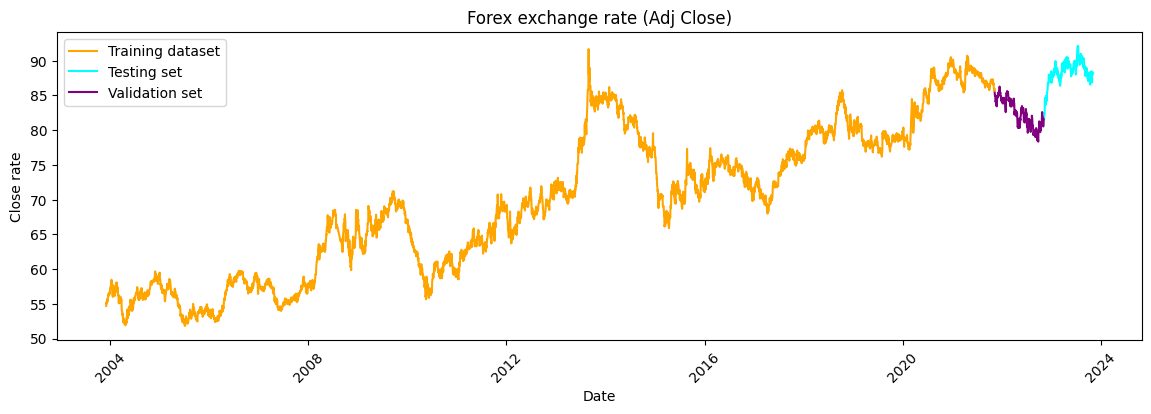

In [46]:
# Assuming you have DataFrames named train, test, and validation with a "Date" column
# Convert the "Date" column to datetime if it's not already
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
validation['Date'] = pd.to_datetime(validation['Date'])

plt.figure(figsize=(14, 4))
plt.plot(train["Date"], train["Adj Close"], color='orange', label='Training dataset')
plt.plot(test["Date"], test["Adj Close"], color='cyan', label='Testing set')
plt.plot(validation["Date"], validation["Adj Close"], color='purple', label='Validation set')

plt.legend()
plt.title('Forex exchange rate (Adj Close)')
plt.xlabel('Date')
plt.ylabel('Close rate')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.savefig('Splitting_of_Data.png')  # Save the plot to a file

plt.show()

**Performing Dickey Fuller Test**

In [47]:
def ad_test_func(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print("1. ADF: ",dftest[0])
    print("2. P-value:",dftest[1])
    print("3.No of Lags",dftest[2])
    print("4.The number of observations utilised for ADF Calculation of regression and critical values",dftest[3])
    print("5.crtical value:")
    for key, val in dftest[4].items():
        print("\t",key,":",val)

In [48]:
ad_test_func(data["Adj Close"])

1. ADF:  -1.114323152521209
2. P-value: 0.7093263292581904
3.No of Lags 26
4.The number of observations utilised for ADF Calculation of regression and critical values 5143
5.crtical value:
	 1% : -3.4316221304407675
	 5% : -2.862102147534257
	 10% : -2.56706923122288


**Make Stationary data for ARIMA model**

<Axes: >

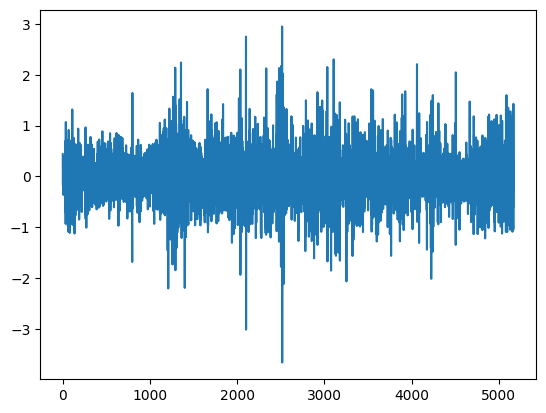

In [49]:
data["Adj Close"].diff(1).dropna().plot()

In [50]:
ad_test_func(data["Adj Close"].diff(1).dropna())

1. ADF:  -14.360063539745028
2. P-value: 9.883205518873921e-27
3.No of Lags 25
4.The number of observations utilised for ADF Calculation of regression and critical values 5143
5.crtical value:
	 1% : -3.4316221304407675
	 5% : -2.862102147534257
	 10% : -2.56706923122288


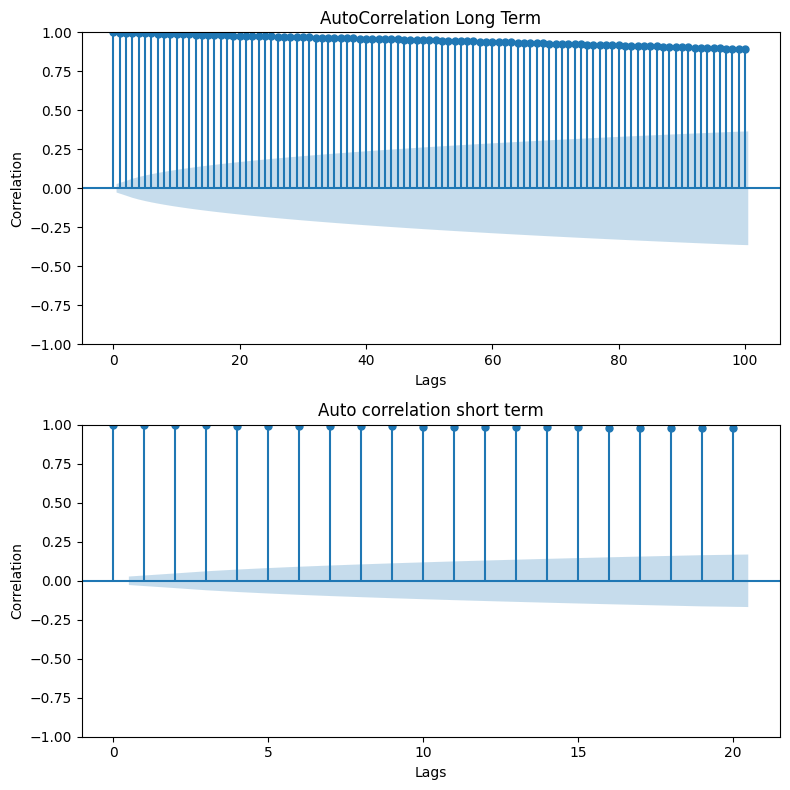

In [51]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))

# Plotting auto-correlation for long term (lags=180)
acf_long_term = plot_acf(data['Adj Close'], lags=100, ax=ax1)
ax1.set_title('AutoCorrelation Long Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')

# Plotting auto-correlation for short term (lags=30)
acf_short_term = plot_acf(data['Adj Close'], lags=20, ax=ax2)
ax2.set_title('Auto correlation short term')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

plt.tight_layout()
plt.savefig('ACF value')

# Displaying the plot
plt.show()

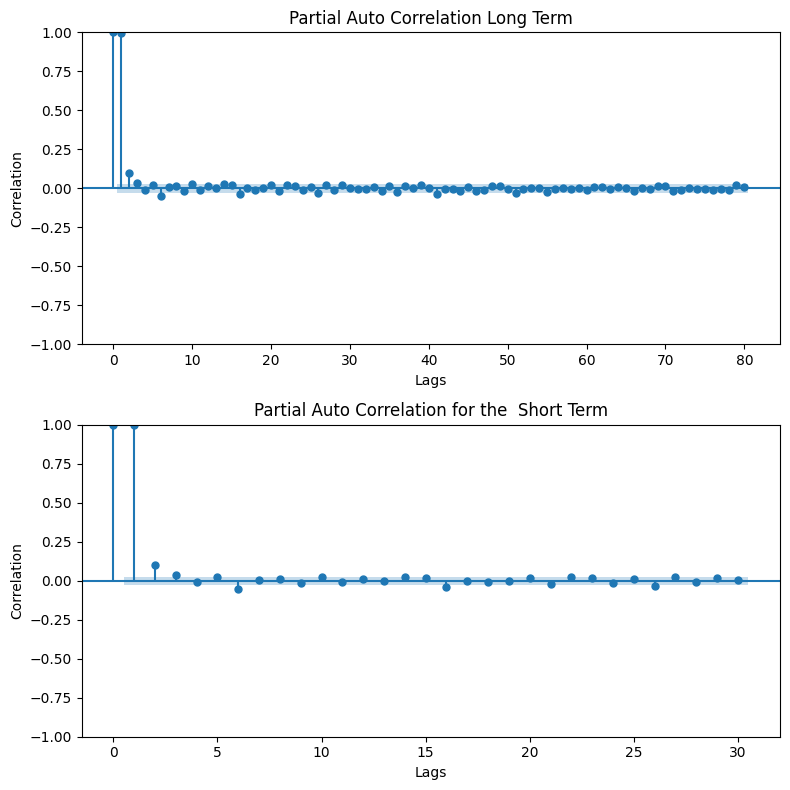

In [52]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))

# Plotting auto-correlation for long term (lags=180)
plot_pacf(data['Adj Close'], lags=80, ax=ax1)
ax1.set_title('Partial Auto Correlation Long Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')

# Plotting auto-correlation for short term (lags=30)
plot_pacf(data['Adj Close'], lags=30, ax=ax2)
ax2.set_title('Partial Auto Correlation for the  Short Term')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('PACF')
# Display the plot
plt.show()

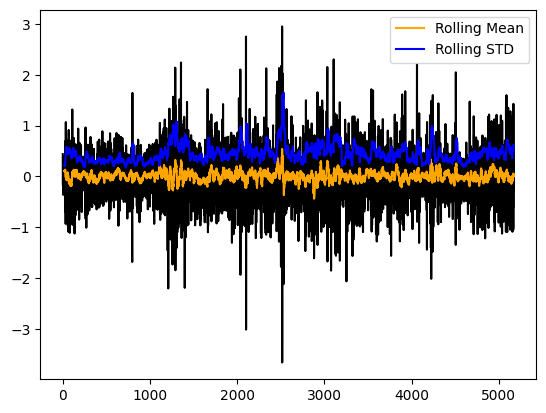

In [53]:
##Differencing
diff_data = data["Adj Close"].diff(1).dropna()

# Plotting the original data
plt.plot(diff_data, c='black')

# Plotting the rolling mean
plt.plot(diff_data.rolling(20).mean(), label='Rolling Mean', c='orange')

# Plotting the rolling standard deviation
plt.plot(diff_data.rolling(20).std(), label='Rolling STD', c='blue')

# Adding legend
plt.legend(prop={'size': 10})

# Displaying the plot
plt.show()

In [54]:
ad_test_func(diff_data)

1. ADF:  -14.360063539745028
2. P-value: 9.883205518873921e-27
3.No of Lags 25
4.The number of observations utilised for ADF Calculation of regression and critical values 5143
5.crtical value:
	 1% : -3.4316221304407675
	 5% : -2.862102147534257
	 10% : -2.56706923122288


**ARIMA model after stationary data**

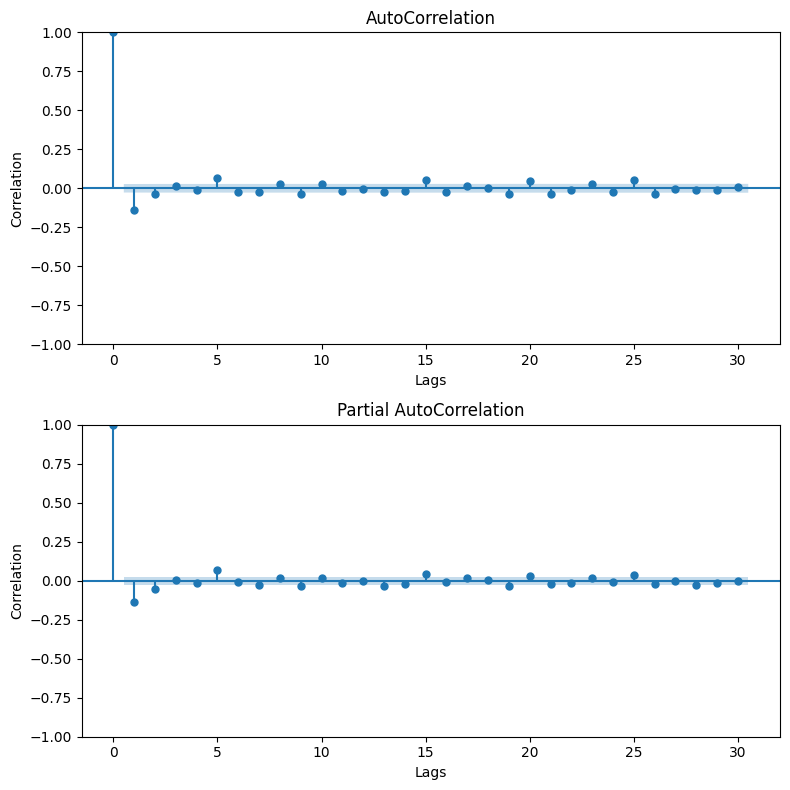

In [55]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))

# Plotting auto-correlation for long term (lags=180)
plot_acf(diff_data, lags=30, ax=ax1)
ax1.set_title('AutoCorrelation')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')

# Plotting auto-correlation for short term (lags=30)
plot_pacf(diff_data, lags=30, ax=ax2)
ax2.set_title('Partial AutoCorrelation')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

# Adjust subplot spacing
plt.tight_layout()

# Display the plot
plt.show()


In [56]:
# Define the sizes of training, testing, and validation sets
diff_train_size = int(len(diff_data) * 0.90)  # 80% of the data for training
diff_test_size = int(len(diff_data) * 0.05)   # 10% of the data for testing
diff_val_size = len(diff_data) - diff_train_size - diff_test_size  # Remaining for validation

# Split the data into training, testing, and validation sets
train_diff = data.iloc[:diff_train_size]
validation_diff = data.iloc[diff_train_size: diff_train_size + diff_test_size]
test_diff = data.iloc[diff_train_size + diff_val_size:]

# Print the shapes of the split sets
print(train_diff.shape, test_diff.shape, validation_diff.shape)

(4652, 11) (259, 11) (258, 11)


In [57]:
train_data_diff = train_diff.filter(['Adj Close'])
train_set_diff = train_data_diff.values

test_data_diff = test_diff.filter(['Adj Close'])
test_set_diff = test_data_diff.values

validation_data_diff = validation_diff.filter(['Adj Close'])
validation_set_diff = validation_data_diff.values

train_set_diff.shape,test_set_diff.shape,validation_set_diff.shape

((4652, 1), (259, 1), (258, 1))

In [58]:
warnings.filterwarnings("ignore")
stepwise_fit = auto_arima(train_diff["Adj Close"], trace=True,suppress_warnings=True, seasonal=False)

print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6389.937, Time=4.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6485.102, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6397.683, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6389.436, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6483.971, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6388.578, Time=1.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6386.554, Time=3.82 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6385.941, Time=0.61 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6387.765, Time=0.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6389.769, Time=0.98 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6385.217, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6396.827, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=6387.024, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6385.772, Time=4.32 sec
 ARIMA(1,1,1)(0,0,0)[0]          

In [59]:
orders= (2,1,0)

model = ARIMA(train_diff['Adj Close'],order=orders )
model = model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 4652
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -3189.608
Date:                Fri, 17 Nov 2023   AIC                           6385.217
Time:                        00:22:38   BIC                           6404.551
Sample:                             0   HQIC                          6392.018
                               - 4652                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1453      0.009    -16.015      0.000      -0.163      -0.127
ar.L2         -0.0541      0.011     -4.816      0.000      -0.076      -0.032
sigma2         0.2308      0.003     77.806      0.0

**ARIMA model validation**

In [60]:
validation_diff['Date'] = pd.to_datetime(validation_diff['Date'])
validation_diff.set_index('Date', inplace=True)

validation_diff

test_diff['Date'] = pd.to_datetime(test_diff['Date'])
test_diff.set_index('Date', inplace=True)

test_diff

,Open,High,Low,Close,Adj Close,Volume,20MA,Upper,Lower,Daily Return
Date,,,,,,,,,,
2022-11-08,81.899002,82.014000,81.388000,81.899002,81.899002,0,81.183800,82.823717,79.543883,0.003775
2022-11-09,81.927002,82.098000,81.303001,81.950996,81.950996,0,81.295100,82.815976,79.774224,0.000635
2022-11-10,81.430000,82.240997,81.120003,81.420998,81.420998,0,81.380550,82.706458,80.054642,-0.006467
2022-11-11,82.120003,83.207001,81.903000,82.108002,82.108002,0,81.474450,82.720896,80.228004,0.008438
2022-11-14,82.166100,83.872002,82.166100,82.399002,82.399002,0,81.592900,82.704323,80.481478,0.003544
...,...,...,...,...,...,...,...,...,...,...
2023-10-30,86.858002,88.396004,86.858002,86.858002,86.858002,0,87.720410,88.704970,86.735850,-0.011854
2023-10-31,88.289001,88.734001,87.921997,88.286003,88.286003,0,87.778860,88.751314,86.806407,0.016441
2023-11-01,87.983002,88.021004,87.560997,87.983002,87.983002,0,87.825261,88.739079,86.911442,-0.003432


In [61]:
# Define the number of forecast steps
num_forecast_steps = len(validation_diff)

# Initialize a list to store the predictions
predictions = []

# Initialize an index for predictions with the same date format
prediction_index = validation_diff.index

# Perform rolling predictions
for i in range(num_forecast_steps):
    # Forecast the next time step
    forecast = model.forecast(steps=1, typ='levels')
    predictions.append(forecast.item())

    # Update the model with the new observed data
    new_observation = validation_diff.iloc[i]['Adj Close']

    # Re-fit the ARIMA model with updated data
    p, d, q = (2, 1, 0)  # Replace with your chosen orders
    model = ARIMA(pd.concat([train_diff['Adj Close'], validation_diff.iloc[:i+1]['Adj Close']]), order=(p, d, q))
    model = model.fit()

# Create a Series with predictions and the original date index
pred_series = pd.Series(predictions, index=prediction_index, name='ARIMA Predictions')

# If you want to compare predictions to actual validation data
predicted_arima = pd.concat([validation_diff['Adj Close'], pred_series], axis=1)

print(predicted_arima)



            Adj Close  ARIMA Predictions
Date                                    
2021-11-10  85.921997          85.612566
2021-11-11  85.385002          85.880809
2021-11-12  84.992996          85.444410
2021-11-15  84.994003          85.079043
2021-11-16  84.526001          85.015082
...               ...                ...
2022-10-31  81.910004          82.105712
2022-11-01  81.755997          81.959400
2022-11-02  81.571999          81.785472
2022-11-03  81.121002          81.606070
2022-11-04  80.527000          81.194331

[258 rows x 2 columns]


In [62]:
rmse_val = rmse_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])

mape_val = mape_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])

mse_val = mse_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])

print("RMSE:", rmse_val)

print("MAPE:", mape_val)

print("MSE:", mse_val)

RMSE: 0.44789093612558156
MAPE: 0.4185990184883386
MSE: 0.20060629066344976


**Arima Model Testing**

In [63]:
model = ARIMA(train_diff['Adj Close'],order= orders)
model = model.fit()

pred = model.forecast(steps=len(validation_diff) ,typ='levels')
pred = pred.rename('ARIMA Predictions')
pred.index = validation_diff.index[:len(pred)]
print(pred.index)

model = pd.concat([train_diff['Adj Close'],validation_diff['Adj Close'],pred])
model

DatetimeIndex(['2021-11-10', '2021-11-11', '2021-11-12', '2021-11-15',
               '2021-11-16', '2021-11-17', '2021-11-18', '2021-11-19',
               '2021-11-22', '2021-11-23',
               ...
               '2022-10-24', '2022-10-25', '2022-10-26', '2022-10-27',
               '2022-10-28', '2022-10-31', '2022-11-01', '2022-11-02',
               '2022-11-03', '2022-11-04'],
              dtype='datetime64[ns]', name='Date', length=258, freq=None)


0                      54.700001
1                      55.139000
2                      55.181000
3                      55.000999
4                      55.370998
                         ...    
2022-10-31 00:00:00    85.614062
2022-11-01 00:00:00    85.614062
2022-11-02 00:00:00    85.614062
2022-11-03 00:00:00    85.614062
2022-11-04 00:00:00    85.614062
Length: 5168, dtype: float64

In [64]:
model = ARIMA(pd.concat([train_diff['Adj Close'],validation_diff['Adj Close']]),order=orders)
model = model.fit()
predictions=[]

for i in range(len(test_diff)):
    # Forecast the next time step
    forecast = model.forecast()
    predictions.append(forecast.item())
    forecast = pd.Series(forecast.item(), index=[test_diff.index[i]])
    #print(forecast)
    model = ARIMA(pd.concat([train_diff['Adj Close'],validation_diff['Adj Close'],forecast]),order=orders)
    model = model.fit()

pred_series = pd.Series(predictions, index=test_diff.index, name='ARIMA Predictions')
predicted_arima = pd.concat([test_diff['Adj Close'], pred_series], axis=1)

print(predicted_arima)

            Adj Close  ARIMA Predictions
Date                                    
2022-11-08  81.899002          80.634257
2022-11-09  81.950996          80.650105
2022-11-10  81.420998          80.663723
2022-11-11  82.108002          80.675423
2022-11-14  82.399002          80.685475
...               ...                ...
2023-10-30  86.858002          80.746793
2023-10-31  88.286003          80.746793
2023-11-01  87.983002          80.746793
2023-11-02  88.046997          80.746793
2023-11-03  88.293999          80.746793

[259 rows x 2 columns]


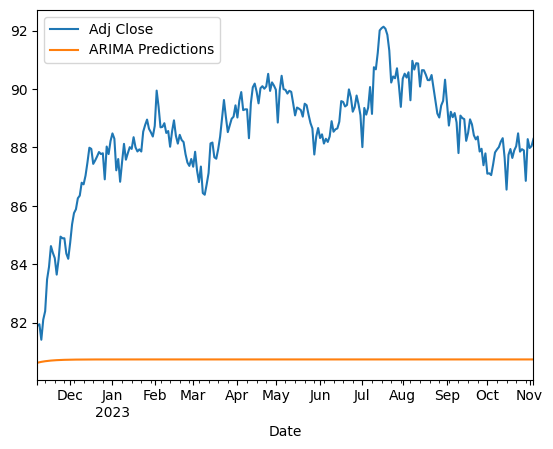

In [65]:
predicted_arima.plot()

plt.savefig('arima prediction')

In [66]:
mape_val = mape_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])
mse_val = mse_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])
rmse_val = rmse_func(predicted_arima['Adj Close'], predicted_arima['ARIMA Predictions'])

print("MAE:", mape_val)
print("MSE:", mse_val)
print("RMSE:", rmse_val)

MAE: 8.655676903349283
MSE: 62.239785072206885
RMSE: 7.88921954772504


## Future prediction using ARIMA

In [ ]:
num_future_days = 14

lastest_date = pd.to_datetime(data['Date'].iat[-1])

# Generate the list of dates for forecast
next_14_days = [lastest_date + datetime.timedelta(days=i) for i in range(1, num_future_days + 1)]
# Print the predicted rates for the next month
for date, price in zip(next_14_days[:14], predicted_arima['ARIMA Predictions']):
    print(f"{date.date()}: {price}")

2023-11-04: 80.6342568287614
2023-11-05: 80.65010518905764
2023-11-06: 80.66372253210434
2023-11-07: 80.6754226914707
2023-11-08: 80.68547541536186
2023-11-09: 80.69411254353007
2023-11-10: 80.70153332229575
2023-11-11: 80.70790897841921
2023-11-12: 80.7133866533168
2023-11-13: 80.71809278576144
2023-11-14: 80.7221360213034
2023-11-15: 80.7256097136909
2023-11-16: 80.72859407578461
2023-11-17: 80.73115802686324


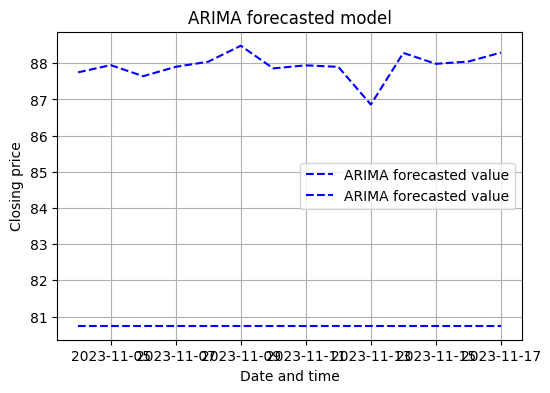

In [ ]:
plt.figure(figsize=(6,4))

plt.plot(next_14_days[:14], predicted_arima[-14:], label='ARIMA forecasted value', linestyle='dashed', color='blue')
plt.xlabel('Date and time')
plt.ylabel('Closing price')
plt.title('ARIMA forecasted model')

plt.legend()
plt.grid(True)
plt.show()